# Tutorial: Intrinsic dimension, Density estimation and Clustering

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from duly import data
from duly.plot import plot_SLAn, plot_MDS, plot_matrix


%load_ext autoreload
%autoreload 2
%matplotlib notebook
%matplotlib inline


In [7]:
#ls

In [16]:

# import a test set
X = np.genfromtxt('datasets/Fig1.dat')

print(X.shape)
# X = np.genfromtxt('Fig2.dat')

# X = np.genfromtxt('FigS1.dat')
# X = np.genfromtxt('FigS2.dat')

# X = np.genfromtxt('FigS3.dat')

#X = np.genfromtxt('FigS4.dat')ls


(20000, 2)


In [17]:
#X = np.random.rand(50000, 2)

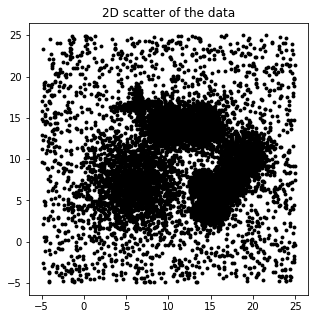

In [18]:
plt.figure(figsize = (5, 5))
plt.title('2D scatter of the data')
plt.scatter(X[:,0],X[:,1],s=15.,alpha=1.0,c='black',linewidths=0.0)
plt.show()

In [19]:
# initialise the Data class
_data = data.Data(X)


In [20]:
# compute distances up to the maxk NN
_data.compute_distances(maxk = 1000, njobs = 1)

Computation of the distances up to 1000 NNs started
Computation of the distances finished


In [21]:
_data.maxk

1000

In [23]:
# estimate ID
_data.compute_id_2NN()

ID estimation finished: selecting ID of 2.01


In [24]:
# estimate ID Bayesian
_data.compute_id_gammaprior(alpha = 2, beta = 2)

ID estimation started, using alpha = 2 and beta = 2


In [25]:
# estimate density with k-NN
_data.compute_density_kNN(k = 10)

k-NN density estimation started (k=10)
k-NN density estimation finished


In [26]:
# estimate density with PAk using cython implementation of Newton-Raphson minimisation
_data.compute_density_PAk()

PAk density estimation started
4.94 seconds optimizing the likelihood for all the points
PAk density estimation finished


In [28]:
# estimate density with PAk using scipy optimisation
# _data.compute_density_PAk(method='NM')

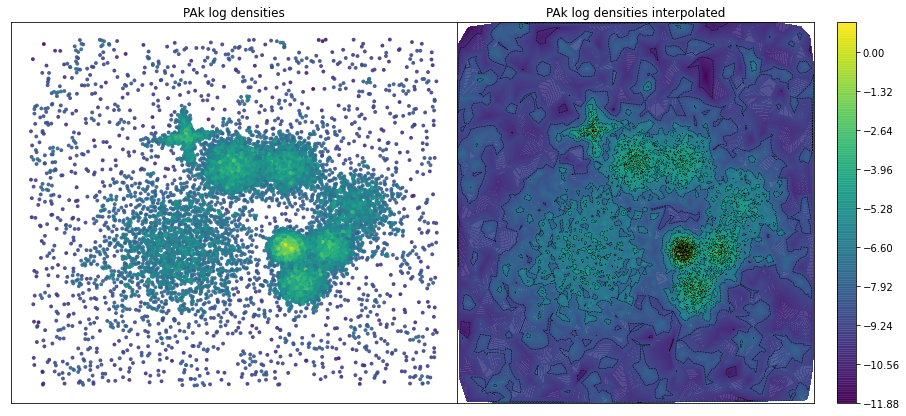

In [29]:
f, [ax1 ,ax2] = plt.subplots(1, 2, figsize = (16, 7),gridspec_kw={'hspace': 0.05, 'wspace': 0})
ax1.yaxis.set_major_locator(plt.NullLocator())
ax1.xaxis.set_major_locator(plt.NullLocator())
ax1.set_title('PAk log densities')

ax1.scatter(X[:,0],X[:,1],s=15.,alpha=0.9, c = _data.Rho,linewidths=0.0)
ax2.yaxis.set_major_locator(plt.NullLocator())
ax2.xaxis.set_major_locator(plt.NullLocator())
ax2.set_title('PAk log densities interpolated')
ax2.tricontour(X[:,0],X[:,1],_data.Rho,levels=10, linewidths=0.5, colors='k')
fig2=ax2.tricontourf(X[:,0],X[:,1],_data.Rho,levels=250,alpha=0.9)

plt.colorbar(fig2)
plt.show()

In [ ]:
# estimate clusters
# _data.compute_clustering(Z = 1, halo=False)

In [37]:
# estimate clusters
_data.compute_clustering_optimised(Z = 1.65, halo=False)

Clustering started
('Number of clusters before multimodality test=', 1294)
0.22 seconds clustering before multimodality test
0.01 seconds identifying the borders
12.05 seconds with multimodality test
0.00 seconds for final operatins
Clustering finished, 21 clusters found
total time is, 12.416649341583252


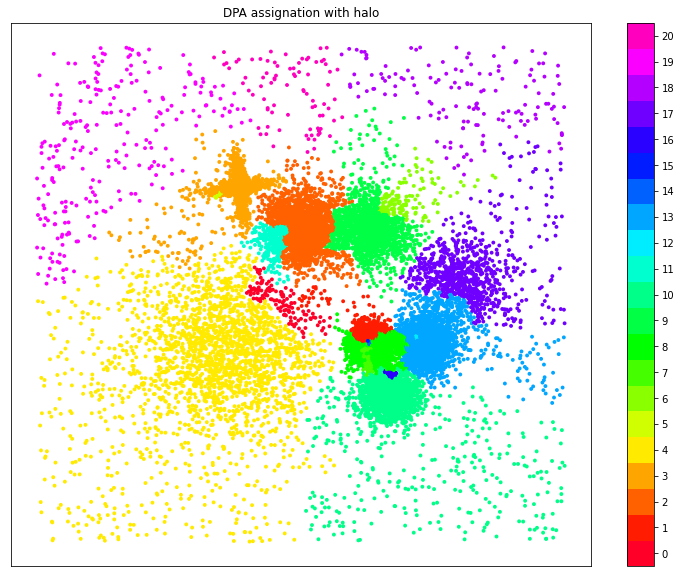

In [38]:

Nclus_m=len(_data.centers_m) 
cmap = plt.get_cmap('gist_rainbow', Nclus_m)
f, ax = plt.subplots(1, 1, figsize = (13, 10))
ax.yaxis.set_major_locator(plt.NullLocator())
ax.xaxis.set_major_locator(plt.NullLocator())
ax.set_title('DPA assignation with halo')
xdtmp=[]
ydtmp=[]
ldtmp=[]
xntmp=[]
yntmp=[]
for j in range(len(_data.labels)):
    if (_data.labels[j]!=-1):
        xdtmp.append(_data.X[j,0]) 
        ydtmp.append(_data.X[j,1])
        ldtmp.append(_data.labels[j])
    else:
        xntmp.append(_data.X[j,0])
        yntmp.append(_data.X[j,1])
        
plt.scatter(xdtmp,ydtmp,s=15.,alpha=1.0, c=ldtmp,linewidths=0.0,cmap=cmap)
plt.colorbar(ticks=range(Nclus_m))
plt.clim(-0.5, Nclus_m-0.5)
plt.scatter(xntmp,yntmp,s=10.,alpha=0.5, c='black',linewidths=0.0)

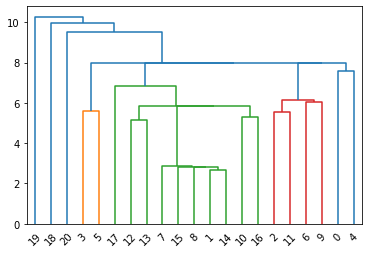

In [39]:
# plot dendogram
plot_SLAn(_data)

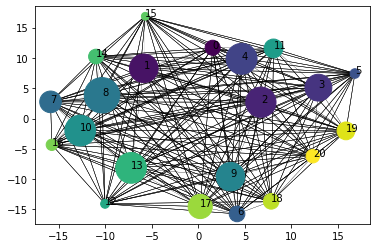

In [40]:
# plot graph of clusters
plot_MDS(_data)

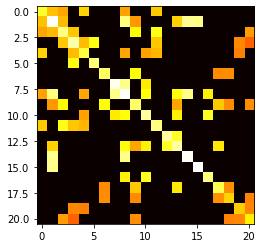

In [41]:
# plot connectivity matrix
plot_matrix(_data)
